# 人臉偵測 - MTCNN (Multi-task Cascaded Convolutional Networks)

這個Notebook主要是介詔使用MTCNN深度學習的網絡來進行人臉的偵測與定位。

MTCNN由3個網絡結構所串連組成（P-Net，R-Net，與O-Net）, 這三個網絡有各自運行的目標:

1. 建議網絡（P-Net）：該網絡結構主要獲得了人臉區域的候選窗口和邊界框的回歸向量，並用該邊界框做回歸，對候選窗口進行校準，然後通過非極大值抑制（NMS）來合併高度重疊的候選框。

2. 細化網絡（R-Net）：該網絡結構還是通過邊界框回歸和NMS來去掉那些假陽性的區域。只是由於該網絡結構和P-Net網絡結構有差異，多了一個全連接層，所以會取得更好的抑制假陽性的作用。

3. 輸出網絡（O-Net）：該層比R-Net層又多了一層卷基層，所以處理的結果會更精細。作用和R-Net層作用一樣。但是該層對人臉區域進行了更多的監督，同時還會輸出5個人臉的Landmark（界標）。


![face-detection](https://allenlu2007.files.wordpress.com/2017/10/mlenewimage.png?w=438&h=600)


![mtcnn-network](http://img.blog.csdn.net/20160927151644359)

參考: [Multi-task Cascaded Convolutional Networks論文](https://arxiv.org/abs/1604.02878v1)

## face-detection-mtcnn 專案說明

[face-detection-mtcnn](https://github.com/ShyBigBoy/face-detection-mtcnn)是基於MTCNN的人臉檢測演算法在Python/Tensorflow的實現。

### 需求

- [Tensorflow >= 1.4](https://www.tensorflow.org/)
- [Python 3.5](https://www.python.org/)
- [OpenCv](https://opencv.org/)

### 安裝

```bash
git clone https://github.com/ShyBigBoy/face-detection-mtcnn.git
cd face-detection-mtcnn
...
```

OpenCV是出了名不容易從源碼編譯安裝的package, 因此建議使用Anaconda來進行OpenCV的安裝:

```
conda install -c conda-forge opencv
```

### 專案的檔案路徑佈局
   
你的目錄結構看起來像這樣: (這裡只列出來在這個範例會用到的相關檔案與目錄)
```
face-detection-mtcnn/
├── xxxx.ipynb
├── det1.npy
├── det2.npy
├── det3.npy
├── detect_face.py
└── data/
    ├── images/                               
    │   └── faces.jpg
    └── videos/                               
        └── shoulder-dance.mp4
```

### STEP 1. 載入相關函式庫

In [1]:
# 把一些警告的訊息暫時関掉
import warnings
warnings.filterwarnings('ignore')

# Utilities相關函式庫
import os
import sys
import random
from tqdm import tqdm
from scipy import misc

# 圖像處理/展現的相關函式庫
import cv2
import matplotlib.pyplot as plt

# 深度學習相關函式庫
import tensorflow as tf

# 專案相關函式庫
import detect_face

#### 設定相關設定與參數

In [2]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 訓練/驗證用的資料目錄
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 訓練/驗證用的圖像資料目錄
TEST_IMGS_PATH = os.path.join(DATA_PATH, "images")

# 訓練/驗證用的影像資料目錄
TEST_VIDEOS_PATH = os.path.join(DATA_PATH, "videos")

#### 設定網絡參數

In [3]:
minsize = 20 # 最小的臉部的大小
threshold = [ 0.6, 0.7, 0.7 ]  # 三個網絡(P-Net, R-Net, O-Net)的閥值
factor = 0.709 # scale factor

gpu_memory_fraction=1.0

### STEP 2. 構建MTCNN網絡架構與模型

In [4]:
print('Creating networks and loading parameters')

# 由於這個mtcnn是使用tensorflow構建而成, 所以需要使用tensorflow執行
with tf.Graph().as_default():
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)
        sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
        with sess.as_default():
            pnet, rnet, onet = detect_face.create_mtcnn(sess, None) # 構建三個網絡(P-Net, R-Net, O-Net)

Creating networks and loading parameters


### STEP 3. 圖像的人臉偵測

In [5]:
# 用來測試mtcnn的人臉偵測的圖像
test_image= os.path.join(TEST_IMGS_PATH, "faces.jpg") # <-- 俢改不同的圖像來比較效果

# 使用OpenCV讀入測試圖像

# 注意: OpenCV讀進來的圖像所產生的Numpy Ndaary格式是BGR (B:Blue, G: Green, R: Red) 
#      跟使用PIL或skimage的格式RGB (R: Red, G: Green, B:Blue)在色階(channel)的順序上有所不同
bgr_image = cv2.imread(test_image)
rgb_image = bgr_image[:,:,::-1] # 把BGR轉換成RGB

# 偵測人臉
bounding_boxes, _ = detect_face.detect_face(rgb_image, minsize, pnet, rnet, onet, threshold, factor)

Total faces detected ：40


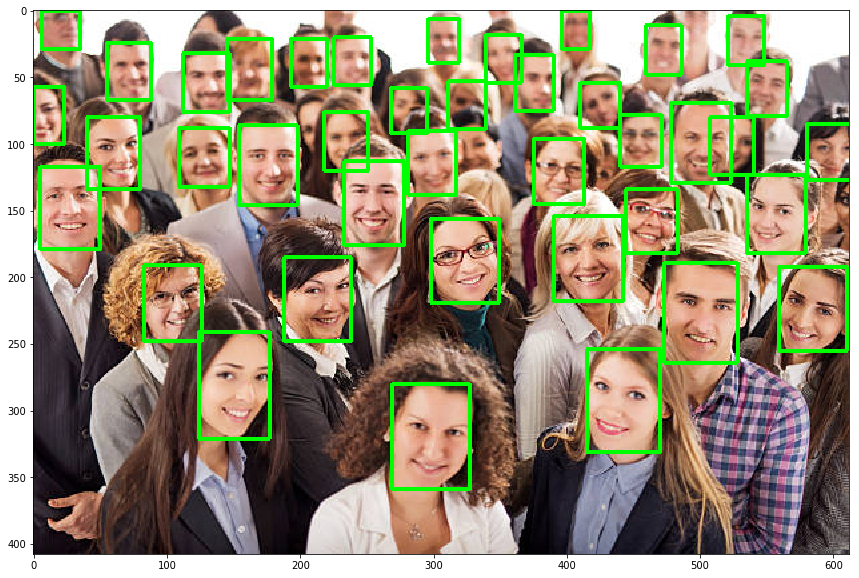

In [6]:
# 複製原圖像
draw = bgr_image.copy()

# 被偵測到的臉部總數
faces_detected = len(bounding_boxes)

print('Total faces detected ：{}'.format(faces_detected))

# 保留裁剪下來的人臉圖像 
crop_faces=[]

# 每一個 bounding_box包括了（x1,y1,x2,y2,confidence score)：
# 　　左上角座標 (x1,y1)
#     右下角座標 (x2,y2)
#     信心分數 confidence score

# 迭代每一個偵測出來的邊界框
for face_position in bounding_boxes:
    # 把資料由float轉成int
    face_position=face_position.astype(int)
    
    # 取出左上角座標 (x1,y1)與右下角座標 (x2,y2)
    # 由於有可能預測出來的臉在圖像的圖邊而導致座標值為負值
    # 因此進行的負值的偵測與修正
    x1 = face_position[0] if face_position[0] > 0 else 0
    y1 = face_position[1] if face_position[1] > 0 else 0
    x2 = face_position[2] if face_position[2] > 0 else 0
    y2 = face_position[3] if face_position[3] > 0 else 0
    
    # 在原圖像上畫上這些邊界框    
    cv2.rectangle(draw, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # 進行臉部圖像裁剪
    crop=bgr_image[y1:y2,x1:x2,]
    
    # 把臉部大小進行大小的修改便拋出給其它模組進行辨識(face recognition)
    # crop = cv2.resize(crop, (96, 96), interpolation=cv2.INTER_CUBIC )
    # crop_faces.append(crop)
    # plt.imshow(crop)
    # plt.show()

# 設定展示的大小
plt.figure(figsize=(20,10))

# 展示偵測出來的結果
plt.imshow(draw[:,:,::-1]) # 轉換成RGB來給matplotlib展示
plt.show()

以上圖像使用OpenCV的Haar來做偵測的話, 只能偵測出**15**張人臉, 而這個mtcnn的演算法則能夠偵測出**40**張人臉!!

### STEP 4. 影像的人臉偵測

In [7]:
# 選擇要進行人臉偵測的影像檔
# 在這個測試我從YOUTUBE下載了: https://www.youtube.com/watch?v=aN862xUWt5I
video_inp =  os.path.join(TEST_VIDEOS_PATH, "shoulder-dance.mp4")

# 偵測結果的輸出影像檔
video_out =  os.path.join(TEST_VIDEOS_PATH, "shoulder-dance-mtcnn.mp4")

# 透過OpenCv擷取影像
video_reader = cv2.VideoCapture(video_inp)

# 取得影像的基本資訊
nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) # 總共有多少frames
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))  # 每個frame的高
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))   # 每個frame的寬

# 找出OpenCV的version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

# 找出原始影像的fps(frame per seconds)
if int(major_ver)  < 3 :
    fps = video_reader.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video_reader.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))
        
# 設定影像的輸出
video_writer = cv2.VideoWriter(video_out,
                               cv2.VideoWriter_fourcc(*'XVID'), 
                               fps, # 設定輸出的fps
                               (frame_w, frame_h))
# 計算有多少人臉被識別出來
total_faces_detected = 0

# 迭代每一個frame來進行圖像偵測
for i in tqdm(range(nb_frames)):
    ret, bgr_image = video_reader.read() # 讀取一個frame
    
    # 把BGR轉換成RGB
    rgb_image = bgr_image[:,:,::-1] 
    
    # 進行人臉偵測
    bounding_boxes, _ = detect_face.detect_face(rgb_image, minsize, pnet, rnet, onet, threshold, factor)
    
    # 把這個frame所識別出來的人臉計數記錄下來
    total_faces_detected += len(bounding_boxes) 
    
    # 迭代每一個偵測的人臉位置 (x, y, w, h) -> 左上角的(x,y)座標, 以及矩型的寬高(w, h)
    for face_position in bounding_boxes:
        face_position=face_position.astype(int)
        #print(face_position[0:4])
        x1 = face_position[0] if face_position[0] > 0 else 0
        y1 = face_position[1] if face_position[1] > 0 else 0
        x2 = face_position[2] if face_position[2] > 0 else 0
        y2 = face_position[3] if face_position[3] > 0 else 0
            
        # 透過OpenCV來把邊界框畫出來       
        cv2.rectangle(bgr_image, (x1, y1), (x2, y2), (0,255,0), 2)
        
    # 透過OpenCV把影像輸出出來
    video_writer.write(bgr_image)
    
video_reader.release() # 釋放資源
video_writer.release() # 釋放資源

print("Total faces detected: ", total_faces_detected)

Frames per second using video.get(cv2.CAP_PROP_FPS) : 29.97002997002997


100%|████████████████████████████████████████████████████████████████████████████| 5264/5264 [3:33:08<00:00,  2.43s/it]


Total faces detected:  55480


### 人臉偵測影像範例

[人臉偵測- MTCNN (Multi-task Cascaded Convolutional Networks)](https://youtu.be/zZZcEu-iZnk)

In [2]:
from IPython.display import HTML

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/zZZcEu-iZnk?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

參考:
* [Multi-task Cascaded Convolutional Networks論文](https://arxiv.org/abs/1604.02878v1)